In [1]:
import pandas as pd 
import numpy as np 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import cv2
from pathlib import Path
import os
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define the dataset path
dataset_path = Path('./fruits-360')
train_path = dataset_path / 'Training'
test_path = dataset_path / 'Test'

# Define which classes are vegetables (to create binary classification)
vegetables = vegetables = verduras = [
    'turnip',
    'raddish',
    'bell pepper',
    'capsicum',
    'Eggplant long 1',
    'Carrot 1',
    'Cabbage white 1',
    'onion',
    'cauliflower',
    'potato',
    'jalepeno',
    'sweetcorn',
    'Zucchini 1',
    'cucumber',
    'Tomato Heart 1',
    'paprika',
    'Onion Red 1',
    'Potato Red 1',
    'Onion White 1',
    'Cauliflower 1',
    'Potato White 1',
    'cabbage',
    'beetroot',
    'Kohlrabi 1',
    'eggplant',
    'Onion Red Peeled 1',
    'Potato Red Washed 1',
    'corn',
    'garlic',
    'carrot',
    'Pepper Green 1',
    'Cucumber Ripe 1',
    'Pepper Orange 1',
    'spinach',
    'lettuce'
]



print(f"Training path exists: {train_path.exists()}")
print(f"Test path exists: {test_path.exists()}")


Training path exists: True
Test path exists: True


In [3]:
def extract_features(image_path):
    img = cv2.imread(str(image_path))
    if img is None:
        return None
    
    img = cv2.resize(img, (100, 100))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    features = []
    
    for i in range(3):
        features.append(np.mean(img_rgb[:, :, i]))
        features.append(np.std(img_rgb[:, :, i]))
        features.append(np.mean(img_rgb[:, :, i]**3) ** (1/3))
    
    for i in range(3):
        features.append(np.mean(img_hsv[:, :, i]))
        features.append(np.std(img_hsv[:, :, i]))
    
    for i in range(3):
        hist = cv2.calcHist([img_rgb], [i], None, [8], [0, 256])
        features.extend(hist.flatten())
    
    grad_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
    
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    features.append(np.mean(gradient_magnitude))
    features.append(np.std(gradient_magnitude))
    
    laplacian_var = cv2.Laplacian(img_gray, cv2.CV_64F).var()
    features.append(laplacian_var)
    
    h, w = img.shape[:2]
    features.append(h / w)
    
    features.append(h * w)
    
    edges = cv2.Canny(img_gray, 50, 150)
    edge_pixels = np.sum(edges > 0)
    features.append(edge_pixels)
    features.append(edge_pixels / (h * w))
    
    features.append(np.mean(img_gray))
    features.append(np.std(img_gray))
    
    median_val = np.median(img_gray)
    features.append(np.sum(img_gray > median_val) / (h * w))
    
    return np.array(features)


In [4]:
def is_vegetable(class_name, vegetables_list):
    return any(veg.lower() in class_name.lower() for veg in vegetables_list)

def load_data(data_path, vegetables_list, max_per_class=200):
    """
    Load images from the dataset and extract features.
    max_per_class limits the number of images per class for faster processing.
    """
    features_list = []
    labels_list = []
    
    class_dirs = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])
    
    print(f"Processing {len(class_dirs)} classes...")
    
    for class_name in class_dirs:
        class_path = data_path / class_name
        image_files = list(class_path.glob('*.jpg'))
        
        image_files = image_files[:max_per_class]
        
        label = 1 if is_vegetable(class_name, vegetables_list) else 0
        
        print(f"Processing {class_name} ({len(image_files)} images) - Label: {'Vegetable' if label == 1 else 'Fruit'}")
        
        for img_path in image_files:
            features = extract_features(img_path)
            if features is not None:
                features_list.append(features)
                labels_list.append(label)
    
    return np.array(features_list), np.array(labels_list)

print("Loading training data...")
X_train, y_train = load_data(train_path, vegetables, max_per_class=200)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Feature vector length: {len(X_train[0])}")
print(f"Class distribution: {np.bincount(y_train)}")
print(f"Number of fruits: {np.sum(y_train == 0)}, Number of vegetables: {np.sum(y_train == 1)}")


Loading training data...
Processing 136 classes...
Processing Apple Braeburn 1 (200 images) - Label: Fruit
Processing Apple Golden 1 (200 images) - Label: Fruit
Processing Apple Golden 2 (200 images) - Label: Fruit
Processing Apple Granny Smith 1 (200 images) - Label: Fruit
Processing Apple Pink Lady 1 (200 images) - Label: Fruit
Processing Apple Red 1 (200 images) - Label: Fruit
Processing Apple Red 2 (200 images) - Label: Fruit
Processing Apple Red 3 (200 images) - Label: Fruit
Processing Apple Red Delicious 1 (200 images) - Label: Fruit
Processing Apple Red Yellow 1 (200 images) - Label: Fruit
Processing Apple Red Yellow 2 (200 images) - Label: Fruit
Processing Apple hit 1 (200 images) - Label: Fruit
Processing Apricot 1 (200 images) - Label: Fruit
Processing Banana Lady Finger 1 (200 images) - Label: Fruit
Processing Banana Red 1 (200 images) - Label: Fruit
Processing Blueberry 1 (200 images) - Label: Fruit
Processing Cabbage white 1 (144 images) - Label: Vegetable
Processing Cactu

In [5]:
print("\nLoading test data...")
X_test, y_test = load_data(test_path, vegetables, max_per_class=100)

print(f"\nTest data shape: {X_test.shape}")
print(f"Class distribution: {np.bincount(y_test)}")
print(f"Number of fruits: {np.sum(y_test == 0)}, Number of vegetables: {np.sum(y_test == 1)}")



Loading test data...
Processing 102 classes...
Processing Apple 6 (100 images) - Label: Fruit
Processing Apple Braeburn 1 (100 images) - Label: Fruit
Processing Apple Crimson Snow 1 (100 images) - Label: Fruit
Processing Apple Pink Lady 1 (100 images) - Label: Fruit
Processing Apple Red 1 (100 images) - Label: Fruit
Processing Apple Red 2 (100 images) - Label: Fruit
Processing Apple Red 3 (100 images) - Label: Fruit
Processing Apple Red Delicious 1 (100 images) - Label: Fruit
Processing Apple Red Yellow 1 (100 images) - Label: Fruit
Processing Apple Red Yellow 2 (100 images) - Label: Fruit
Processing Apple hit 1 (100 images) - Label: Fruit
Processing Apricot 1 (100 images) - Label: Fruit
Processing Banana Lady Finger 1 (100 images) - Label: Fruit
Processing Banana Red 1 (100 images) - Label: Fruit
Processing Blueberry 1 (100 images) - Label: Fruit
Processing Cabbage white 1 (47 images) - Label: Vegetable
Processing Cactus fruit 1 (100 images) - Label: Fruit
Processing Cantaloupe 2 (10

In [6]:
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")



Scaling features...
Features scaled successfully!


In [7]:
print("Training SVM...")
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True, class_weight='balanced')
svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"\nSVM Accuracy: {accuracy_svm:.4f}")

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Fruit', 'Vegetable']))


Training SVM...

SVM Accuracy: 0.9514

SVM Classification Report:
              precision    recall  f1-score   support

       Fruit       0.99      0.95      0.97      8383
   Vegetable       0.78      0.95      0.86      1538

    accuracy                           0.95      9921
   macro avg       0.89      0.95      0.91      9921
weighted avg       0.96      0.95      0.95      9921



In [8]:
print("\n\nTraining Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest Accuracy: {accuracy_rf:.4f}")

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Fruit', 'Vegetable']))




Training Random Forest...

Random Forest Accuracy: 0.9569

Random Forest Classification Report:
              precision    recall  f1-score   support

       Fruit       0.97      0.98      0.97      8383
   Vegetable       0.88      0.84      0.86      1538

    accuracy                           0.96      9921
   macro avg       0.92      0.91      0.92      9921
weighted avg       0.96      0.96      0.96      9921



In [9]:
feature_importance = rf_model.feature_importances_
important_indices = np.argsort(feature_importance)[::-1][:10]

print("\nTop 10 Most Important Features (Random Forest):")
for idx, feat_idx in enumerate(important_indices, 1):
    print(f"{idx}. Feature {feat_idx}: Importance = {feature_importance[feat_idx]:.4f}")



Top 10 Most Important Features (Random Forest):
1. Feature 2: Importance = 0.0537
2. Feature 37: Importance = 0.0513
3. Feature 12: Importance = 0.0450
4. Feature 21: Importance = 0.0442
5. Feature 11: Importance = 0.0424
6. Feature 6: Importance = 0.0376
7. Feature 19: Importance = 0.0349
8. Feature 29: Importance = 0.0328
9. Feature 38: Importance = 0.0291
10. Feature 41: Importance = 0.0281


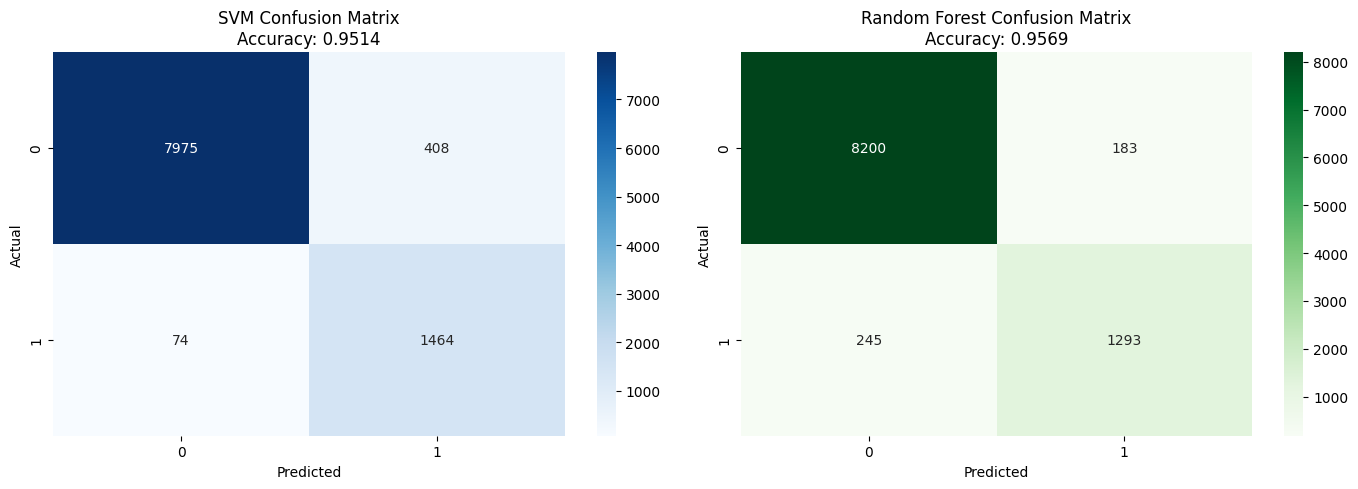


Model Comparison Summary:
SVM Accuracy:        0.9514 (95.14%)
Random Forest Accuracy: 0.9569 (95.69%)


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'SVM Confusion Matrix\nAccuracy: {accuracy_svm:.4f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title(f'Random Forest Confusion Matrix\nAccuracy: {accuracy_rf:.4f}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

print("\nModel Comparison Summary:")
print("=" * 50)
print(f"SVM Accuracy:        {accuracy_svm:.4f} ({accuracy_svm*100:.2f}%)")
print(f"Random Forest Accuracy: {accuracy_rf:.4f} ({accuracy_rf*100:.2f}%)")
print("=" * 50)


## Predict on Your Own Image

Upload or provide the path to your own image and use the function below to predict if it's a fruit or vegetable.


In [11]:
def detailed_prediction(image_path):
    if not Path(image_path).exists():
        print(f"Error: Image not found at {image_path}")
        return
    
    features = extract_features(image_path)
    if features is None:
        print("Error: Could not extract features from image")
        return
    
    features_scaled = scaler.transform(features.reshape(1, -1))
    
    svm_pred = svm_model.predict(features_scaled)[0]
    svm_proba = svm_model.predict_proba(features_scaled)[0]
    
    rf_pred = rf_model.predict(features_scaled)[0]
    rf_proba = rf_model.predict_proba(features_scaled)[0]
    
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    axes[0].imshow(img_rgb)
    axes[0].axis('off')
    axes[0].set_title('Your Image', fontsize=16, fontweight='bold')
    
    axes[1].axis('off')
    
    svm_label = "VEGETABLE" if svm_pred == 1 else "FRUIT"
    svm_conf = f"{svm_proba[svm_pred]*100:.1f}%" if svm_proba is not None else "N/A"
    
    rf_label = "VEGETABLE" if rf_pred == 1 else "FRUIT"
    rf_conf = f"{rf_proba[rf_pred]*100:.1f}%"
    
    result_text = f"""
    PREDICTION RESULTS
    {'='*40}
    
    SVM Model:
    ➤ {svm_label}
    ➤ Confidence: {svm_conf}
    
    Random Forest Model:
    ➤ {rf_label}
    ➤ Confidence: {rf_conf}
    
    {'='*40}
    """
    
    axes[1].text(0.1, 0.5, result_text, fontsize=14, family='monospace',
                 verticalalignment='center')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nDetailed Results:")
    print(f"Image: {Path(image_path).name}")
    print(f"\nSVM: {svm_label} (Confidence: {svm_conf})")
    print(f"Random Forest: {rf_label} (Confidence: {rf_conf})")
    
    return {
        'svm': {'prediction': svm_pred, 'probability': svm_proba, 'label': svm_label},
        'rf': {'prediction': rf_pred, 'probability': rf_proba, 'label': rf_label}
    }

print("Detailed prediction function ready!")
print("\nUsage:")
print("result = detailed_prediction('/path/to/your/image.jpg')")


Detailed prediction function ready!

Usage:
result = detailed_prediction('/path/to/your/image.jpg')


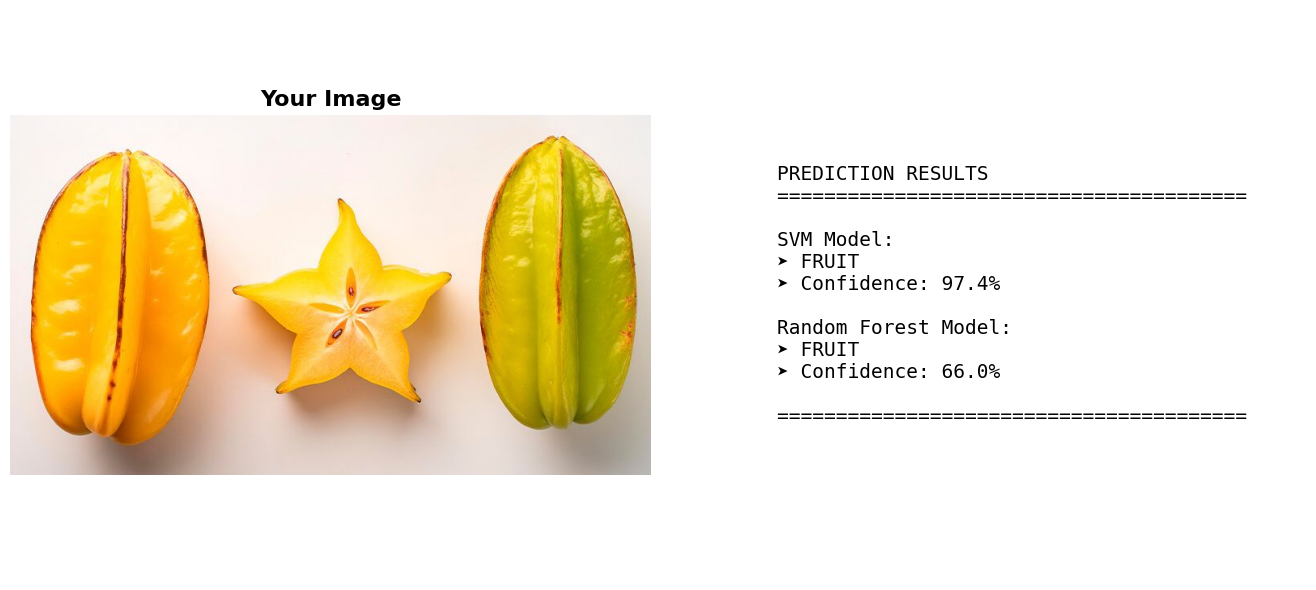


Detailed Results:
Image: web_carambola2_c5cf8b99bd.jpg

SVM: FRUIT (Confidence: 97.4%)
Random Forest: FRUIT (Confidence: 66.0%)


In [22]:
YOUR_IMAGE_PATH = 'web_carambola2_c5cf8b99bd.jpg'  # <-- Change this to your image path

results = detailed_prediction(YOUR_IMAGE_PATH)


## Feature Extraction Pipeline Summary

This pipeline extracts **58 features** from each image:

### 1. Color Features (30 features)
- **RGB Color Moments**: Mean, standard deviation, and skewness for each RGB channel (9 features)
- **HSV Color Moments**: Mean and standard deviation for each HSV channel (6 features)
- **Color Histograms**: 8-bin histogram for each RGB channel (24 features)

### 2. Texture Features (4 features)
- **Gradient Magnitude**: Mean and standard deviation of gradient magnitude
- **Laplacian Variance**: Measure of image sharpness/texture

### 3. Shape Features (4 features)
- **Aspect Ratio**: Height/Width ratio
- **Area**: Total pixel count
- **Edge Count**: Number of edge pixels
- **Edge Density**: Ratio of edge pixels to total pixels

### 4. Statistical Features (3 features)
- **Brightness**: Mean and standard deviation of grayscale values
- **Pixels Above Median**: Ratio of pixels above the median brightness

### Models Used:
1. **Support Vector Machine (SVM)**: RBF kernel with C=1.0
2. **Random Forest**: 100 estimators with max_depth=20

Both models use **StandardScaler** for feature normalization before training.
